In [1]:
import os
import numpy as np
from abc import ABC, abstractmethod
from jpype import *
import tqdm
import matplotlib.pyplot as plt
from scipy.signal import convolve



In [2]:
from utils import participant_ids, raw_data_path, find_trials, import_soa_rating_data, import_emg_data, onset_detection, extract_onset_time

In [12]:
participant = participant_ids[-1]
trials = find_trials(participant)
trial = trials[-3]
print(f"Participant: {participant}, Trial: {trial}")

data_beh = import_soa_rating_data(participant)
data_emg = import_emg_data(participant, trial)


Participant: 20250312, Trial: 10


c:\SynologyDrive\DeepWen\deepwen\home\acercyc\Projects\Drum\src\ana_20250225\utils.py:60: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=0, names=column_names, usecols=range(9))


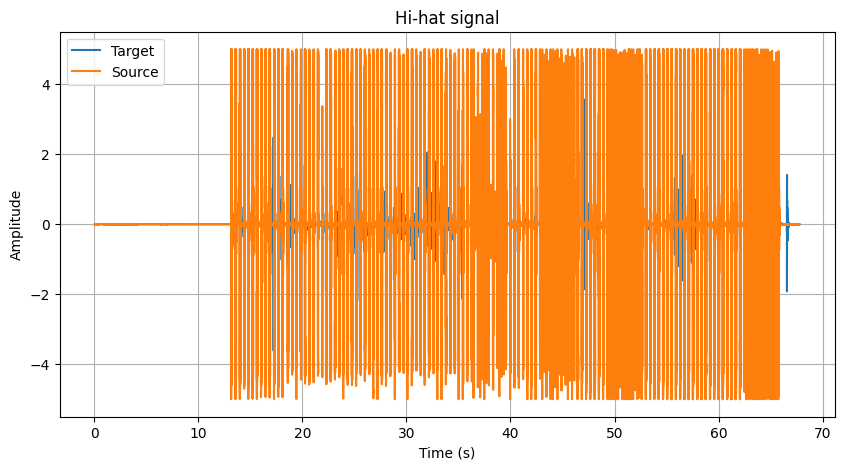

In [13]:
target = data_emg['Hi-hat'].values
source = data_emg['Hi-hat (cue)'].values
t = data_emg['Time'].values

# plot the target signal
fig = plt.figure(figsize=(10, 5))
plt.plot(t, target)
plt.plot(t, source)
plt.legend(['Target', 'Source'])
plt.title('Hi-hat signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.xlim([20, 30])
plt.grid(True)
plt.show()

    

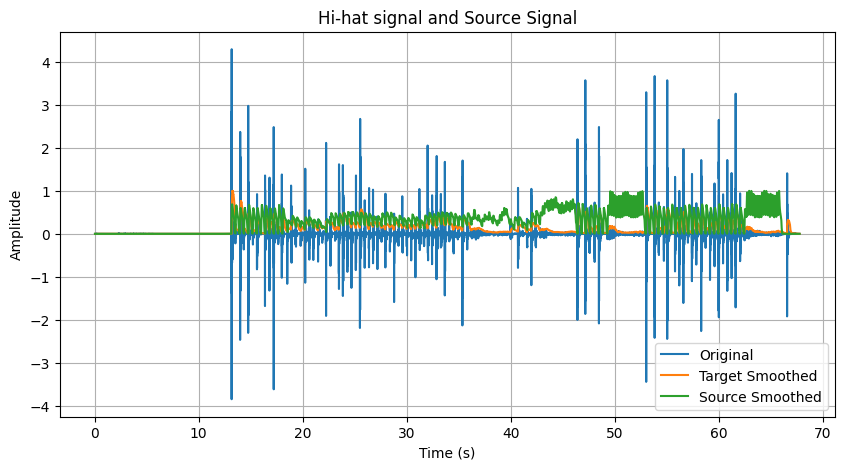

In [14]:
# convolue
def convolve_with_exponential_kernel(data, decay_rate, kernel_size):
    """
    Convolve a column with an exponential kernel for smoothing.

    Parameters:
    - data (np.array): The data to be smoothed.
    - decay_rate (float): The decay rate (lambda) for the exponential kernel.

    Returns:
    - np.array: The convolved data.
    """
    kernel = np.exp(-decay_rate * np.linspace(0, 1, kernel_size))
    # kernel /= kernel.sum()  # Normalize kernel to maintain scale

    data_cov = np.convolve(data, kernel, mode="same")
    return data_cov


def impulse_response_convolution(
    data, peak_amplitude=1.0, decay_rate=0.001, response_length=200
):
    """
    Applies an impulse response function with exponential decay using convolution.

    Parameters:
        time_series (numpy array): The input time series (e.g., binary impulses).
        peak_amplitude (float): The peak height of the response.
        decay_rate (float): The exponential decay rate (higher means faster decay).
        response_length (int): The length of the impulse response function.

    Returns:
        numpy array: The output signal with impulse responses applied.
    """
    # Generate the impulse response kernel
    data = np.abs(data)
    t = np.arange(response_length)
    impulse_response_kernel = peak_amplitude * np.exp(-decay_rate * t)

    # Apply convolution
    output_signal = convolve(data, impulse_response_kernel, mode="full")[: len(data)]

    # Normalize the output signal
    output_signal /= np.max(output_signal)

    return output_signal



decay_rate = 0.001
response_length = 1000
target_cov = impulse_response_convolution(
    target, peak_amplitude=1, decay_rate=decay_rate, response_length=response_length
)

source_cov = impulse_response_convolution(
    source, peak_amplitude=1, decay_rate=decay_rate, response_length=response_length
)

# plot the target signal
fig = plt.figure(figsize=(10, 5))
plt.plot(t, target, label="Original")
plt.plot(t, target_cov, label="Target Smoothed")
plt.plot(t, source_cov, label="Source Smoothed")
plt.title("Hi-hat signal and Source Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.xlim([20, 30])
plt.legend()
plt.grid(True)
plt.show()

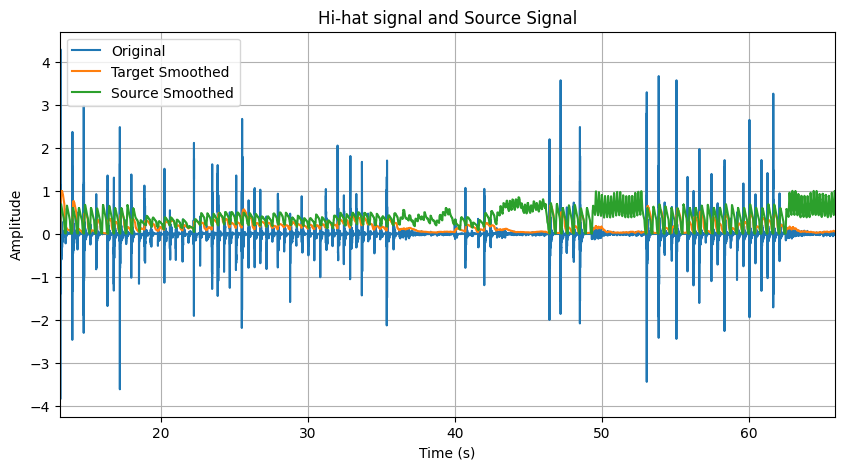

In [15]:
# find the first and last source onset
onsets_array, onset_idx = onset_detection(source, threshold=0.1, minimal_interval=1000)
idx_start = onset_idx[0]
idx_end = onset_idx[-1]

# plot the target signal
fig = plt.figure(figsize=(10, 5))  
plt.plot(t, target, label="Original")
plt.plot(t, target_cov, label="Target Smoothed")
plt.plot(t, source_cov, label="Source Smoothed")
plt.title("Hi-hat signal and Source Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim([t[idx_start], t[idx_end]])
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# truncate the signals
target_ = target_cov[idx_start:idx_end]
source_ = source_cov[idx_start:idx_end]
t_ = t[idx_start:idx_end]

# down sample the signals
# original sampling rate is 4000 Hz
original_sampling_rate = 4000
down_sampling_rate = 100 # Hz
down_sample_point = int(original_sampling_rate / down_sampling_rate)
target_ = target_[::down_sample_point]
source_ = source_[::down_sample_point]
t_ = t_[::down_sample_point]

In [17]:
# locate jitd jar file
from pathlib import Path
import sys

sys.path.append(
    "../"
)


from TE import TransferEntropyCalculator_continuous_kraskov

te_calc = TransferEntropyCalculator_continuous_kraskov()
window_size_time = 3 # seconds
window_size = window_size_time * down_sampling_rate
step_size_time = 1 # seconds
step_size = int(step_size_time * down_sampling_rate)
window_centers, te_values = te_calc.compute_TE_moving_window(
    source_, target_, window_size, step_size)

Computing moving window: 100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


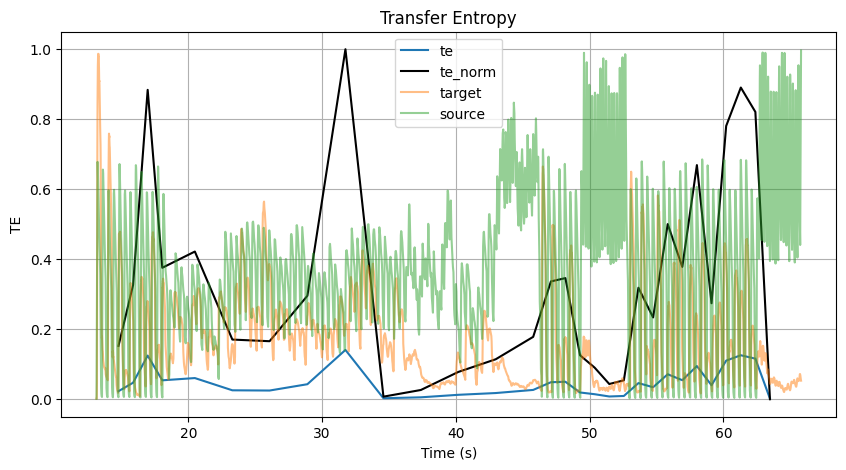

In [18]:
window_centers = np.array(window_centers)
te_values = np.array(te_values)
# normalise to [0, 1]
te_values_norm = (te_values - np.min(te_values)) / (np.max(te_values) - np.min(te_values))

# plot te
fig = plt.figure(figsize=(10, 5))
plt.plot(t_[window_centers], te_values)
plt.plot(t_[window_centers], te_values_norm, 'k')
plt.plot(t_, target_, alpha=0.5)
plt.plot(t_, source_, alpha=0.5)
plt.title("Transfer Entropy")
plt.xlabel("Time (s)")
plt.ylabel("TE")
# plt.xlim([50, 70])
plt.grid(True)
plt.legend(['te', 'te_norm', 'target', 'source'])
plt.show()
